In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import sys

# plase change this to your corresponding folder
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'stat-453'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['data', '__pycache__', 'models', 'model.py', 'videos', 'stat_453', 'experiment.json', 'stat_453_test', 'STAT 453.gslides', 'diffusion.py', 'noise_testing']


In [ ]:
def betas_for_alpha_bar(
    num_diffusion_timesteps,
    max_beta=0.999,
    alpha_transform_type="cosine",
):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function, which defines the cumulative product of
    (1-beta) over time from t = [0,1].

    Contains a function alpha_bar that takes an argument t and transforms it to the cumulative product of (1-beta) up
    to that part of the diffusion process.


    Args:
        num_diffusion_timesteps (`int`): the number of betas to produce.
        max_beta (`float`): the maximum beta to use; use values lower than 1 to
                     prevent singularities.
        alpha_transform_type (`str`, *optional*, default to `cosine`): the type of noise schedule for alpha_bar.
                     Choose from `cosine` or `exp`

    Returns:
        betas (`np.ndarray`): the betas used by the scheduler to step the model outputs
    """
    if alpha_transform_type == "cosine":

        def alpha_bar_fn(t):
            return math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2

    elif alpha_transform_type == "exp":

        def alpha_bar_fn(t):
            return math.exp(t * -12.0)

    else:
        raise ValueError(f"Unsupported alpha_transform_type: {alpha_transform_type}")

    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar_fn(t2) / alpha_bar_fn(t1), max_beta))
    return torch.tensor(betas, dtype=torch.float32)

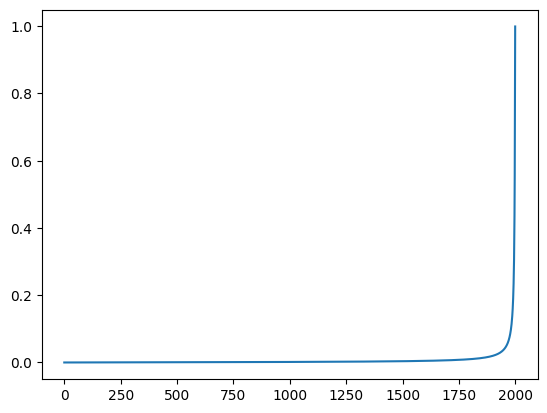

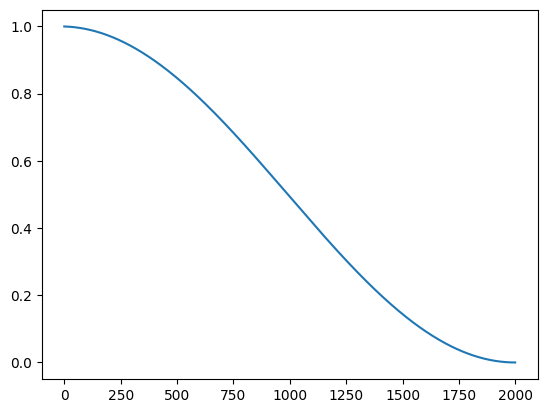

torch.Size([2000])
torch.Size([2000])
torch.Size([2000])
tensor(1.0000)


In [ ]:
import math
import torch
betas = betas_for_alpha_bar(num_diffusion_timesteps=2000, max_beta=0.999)

import matplotlib.pyplot as plt
plt.plot(betas)
plt.show()

alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
plt.plot(alphas_cumprod)
plt.show()

print(betas.shape)
print(alphas.shape)
print(alphas_cumprod.shape)
print(alphas_cumprod[0])

In [ ]:
def get_beta(alpha_hat):
    beta = alpha_hat[1:] / alpha_hat[:-1]
    return (1 - beta).clamp(max = 0.999)

def get_alpha_hat(T):
    s = 0.008
    t = torch.arange(T + 1, dtype = torch.float64, device = "cpu") / T
    alpha_hat = torch.cos(((t + s)/ (1 + s)) * (math.pi / 2.0)) ** 2

    # start = 1.0
    # end= 0.01
    # alpha_hat = torch.linspace(start, end, steps=self.T, self.dtype, device = self.device)
    alpha_hat[1:] /= alpha_hat[0]
    return alpha_hat

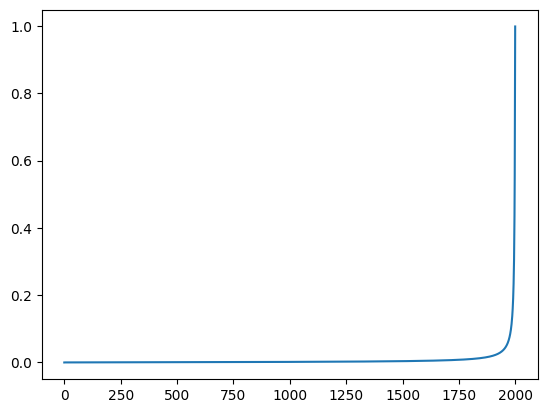

tensor(0.9990, dtype=torch.float64)
torch.Size([2000])
tensor(0.9990, dtype=torch.float64)
tensor(0.7500, dtype=torch.float64)
tensor(0.0002, dtype=torch.float64)
torch.Size([2001])


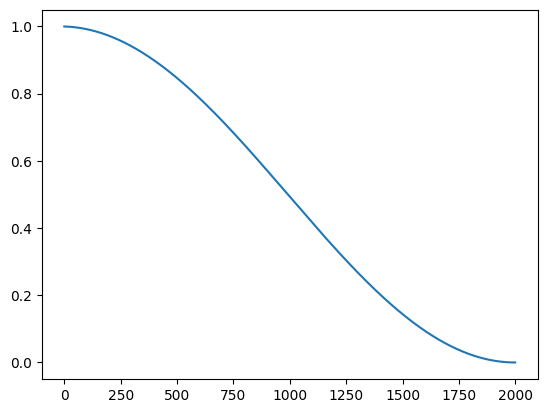

tensor(3.7500e-33, dtype=torch.float64)
tensor(6.0719e-07, dtype=torch.float64)
tensor(6.1759e-27, dtype=torch.float64)
tensor(0.0003, dtype=torch.float64)


In [ ]:
beta = get_beta(get_alpha_hat(2000))
plt.plot(beta)
plt.show()
print(torch.max(beta))
print(beta.shape)
print(beta[-1])
print(beta[-2])

print(torch.sum(torch.abs(beta - betas)))

alpha_hat = get_alpha_hat(2000)
print(alpha_hat.shape)
plt.plot(alpha_hat[1:])
plt.show()

print(alpha_hat[-1])
print(alpha_hat[-2])
print(alpha_hat[-1] / alpha_hat[-2])
print(torch.sum(torch.abs(alpha_hat[1:] - alphas_cumprod)))

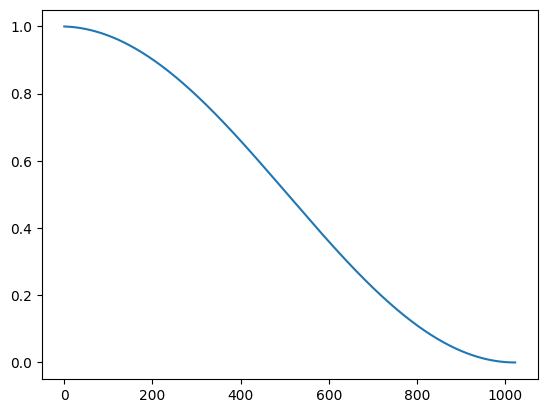

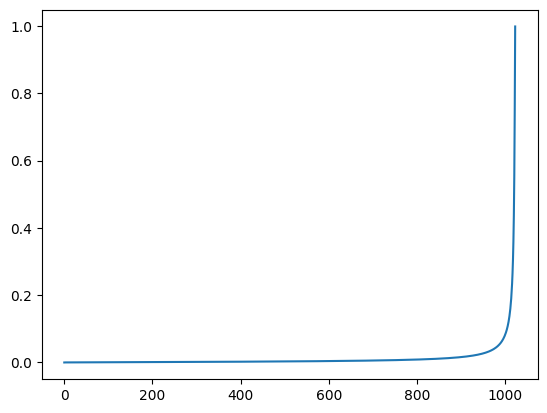

In [ ]:
from diffusion import ImprovedDiffusion
image_size = 64
dtype = torch.float32
DEVICE = "cpu"
diffusion = ImprovedDiffusion(1024, (image_size, image_size), dtype = dtype, device = DEVICE)

alphas = diffusion.alpha_hat
plt.plot(alphas.cpu())
plt.show()

beta = diffusion.beta
plt.plot(beta.cpu())
plt.show()


In [ ]:
image_size = 64
batch_size = 28

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils import data as data_utils

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([
                               transforms.Resize((image_size, image_size)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

print("Total number of classes in the dataset: ", len(dataset))
print("Number of different samples in the dataset: ", len(dataset.classes))

train_dataloader = data_utils.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers = 12,
                                        )

100%|██████████| 170498071/170498071 [00:10<00:00, 15540812.77it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Total number of classes in the dataset:  50000
Number of different samples in the dataset:  10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

In [ ]:
first_image = dataset[0][0]
plt.imshow(first_image.cpu().permute(1, 2, 0))
plt.show()
show_tensor_image(first_image)

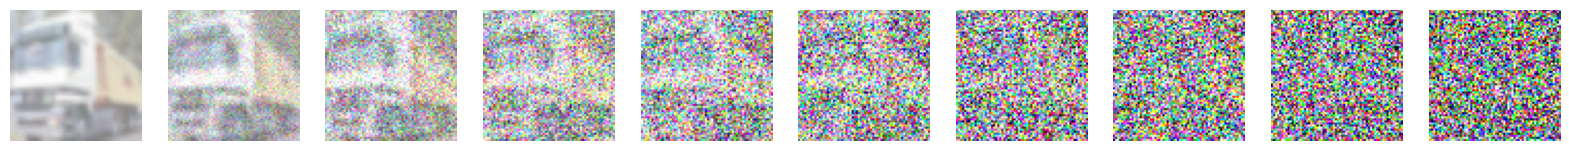

In [ ]:
from diffusion import ImprovedDiffusion
diffusion1 = ImprovedDiffusion(1000, (image_size, image_size), dtype = dtype, device = DEVICE)
first_image = (dataset[1][0].to(device = DEVICE) + 1) / 2

images = []

for i in range(1000):
  temp, noise = diffusion.get_noise(first_image, torch.tensor([i]))
  if i % 100 == 0:
    images.append(temp[0].cpu())
from IPython.display import clear_output
clear_output(wait=True)
fig, ax = plt.subplots(1, 10, figsize = (20, 20))

for idx in range(10):
  image = (images[idx].clamp(-1, 1) + 1) / 2
  ax[idx].imshow(image.permute(1, 2, 0))
  ax[idx].axis('off')
plt.show()

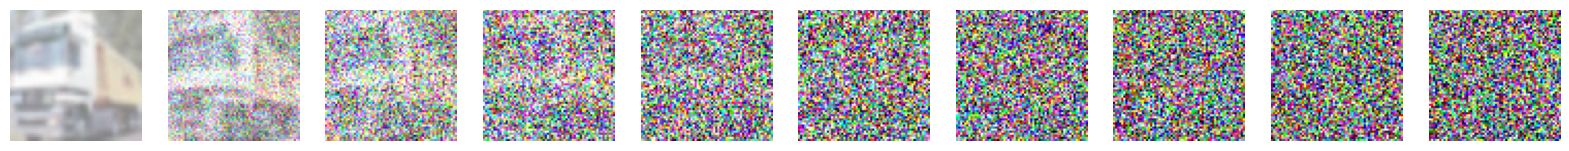

In [ ]:
from diffusion import Diffusion
diffusion1 = Diffusion(1000, (image_size, image_size), dtype = dtype, device = DEVICE)
first_image = (dataset[1][0].to(device = DEVICE) + 1) / 2

images = []

for i in range(1000):
  temp, noise = diffusion.get_noise(first_image, torch.tensor([i]))
  if i % 100 == 0:
    images.append(temp[0].cpu())
from IPython.display import clear_output
clear_output(wait=True)
fig, ax = plt.subplots(1, 10, figsize = (20, 20))

for idx in range(10):
  image = (images[idx].clamp(-1, 1) + 1) / 2
  ax[idx].imshow(image.permute(1, 2, 0))
  ax[idx].axis('off')
plt.show()

In [ ]:
print(torch.max(diffusion.alpha_hat))
print(torch.min(diffusion.alpha_hat))
print(torch.max(diffusion.beta))
print(torch.min(diffusion.beta))

In [ ]:
print(diffusion.alpha_hat.shape)
print(diffusion.beta.shape)
print(diffusion.T)

In [ ]:
from model import UNet
import numpy as np
import matplotlib.pyplot as plt
num_classes = len(dataset.classes)
model = UNet(num_classes = num_classes, device = DEVICE).to(device = DEVICE)

pokemon_dict = dataset.class_to_idx
dtype = dataset.__getitem__(0)[0].dtype
name = "Bulbasaur"
noise = torch.randn((1, 3, image_size, image_size), dtype = dtype, device = DEVICE)
label = torch.tensor([pokemon_dict[name]], dtype = torch.long, device = DEVICE)
image = diffusion.inference(model, noise, label = label)
plt.imshow(np.transpose(image.cpu().squeeze(), (1, 2, 0)))

In [ ]:
show_tensor_image(image.cpu())

In [ ]:
plt.imshow(np.transpose(image.cpu().squeeze(), (1, 2, 0)))
plt.show()

In [ ]:
print(image)